In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
posts_df = pd.read_json('data/stackoverflow/sample/CombinedDocs.100K.Questions.jsonl.gz', lines=True)
print('Original posts: {:,}'.format(len(posts_df.index)))
posts_df.head(5)

Original posts: 273,876


,Comments,_AcceptedAnswerId,_AnswerCount,_Body,_ClosedDate,_CommentCount,_CommunityOwnedDate,_CreationDate,_FavoriteCount,_Id,...,_Owner,_OwnerDisplayName,_OwnerUserId,_ParentId,_PostTypeId,_Score,_Tags,_Title,_ViewCount,_Votes
0,"[{'_CreationDate': '2013-02-20T21:15:11.130', ...",NaN,NaN,"<p>What event do you want to use as trigger, t...",None,7,None,2013-02-20T21:15:11.130,NaN,14990058,...,{'_AboutMe': '<ul> <li>ASP.NET and Windows-Dev...,None,284240,14989981.0,2,2,None,None,NaN,"[{'_BountyAmount': None, '_CreationDate': '201..."
1,"[{'_CreationDate': '2015-09-14T22:02:20.670', ...",NaN,NaN,"<p>When the build/publish script ran, the wron...",None,0,None,2015-09-14T22:02:20.670,NaN,32574652,...,{'_AboutMe': '<p>Keith lives in SE Florida and...,None,86555,32569215.0,2,0,None,None,NaN,"[{'_BountyAmount': None, '_CreationDate': '201..."
2,"[{'_CreationDate': '2012-06-12T14:02:37.243', ...",NaN,NaN,<p>In the interface add the method declaration...,None,3,None,2012-06-12T14:02:37.243,NaN,10998316,...,"{'_AboutMe': '<h1>SOreadytohelp</h1> ', '_Acco...",None,693272,10998270.0,2,3,None,None,NaN,"[{'_BountyAmount': None, '_CreationDate': '201..."
3,"[{'_CreationDate': '2014-07-30T13:14:15.723', ...",NaN,NaN,<p>Every answer so far is correct and points o...,None,0,None,2014-07-30T13:14:15.723,NaN,25037786,...,{'_AboutMe': '<p>Expertise with</p> <ul> <li>...,None,1649198,25037558.0,2,0,None,None,NaN,None
4,"[{'_CreationDate': '2009-08-19T20:18:55.647', ...",NaN,1.0,<p>This is what i have.</p>\n\n<pre><code>$num...,None,0,None,2009-08-19T20:18:55.647,NaN,1302404,...,None,None,115949,NaN,1,0,<php>,Break apart variable contents and load into ar...,337.0,None


In [3]:
tag_posts = posts_df.dropna(axis=0, subset=['_Tags'])
print('Posts w/ tags: {:,}'.format(len(tag_posts.index)))
tag_posts.head(5)

Posts w/ tags: 98,278


,Comments,_AcceptedAnswerId,_AnswerCount,_Body,_ClosedDate,_CommentCount,_CommunityOwnedDate,_CreationDate,_FavoriteCount,_Id,...,_Owner,_OwnerDisplayName,_OwnerUserId,_ParentId,_PostTypeId,_Score,_Tags,_Title,_ViewCount,_Votes
4,"[{'_CreationDate': '2009-08-19T20:18:55.647', ...",NaN,1.0,<p>This is what i have.</p>\n\n<pre><code>$num...,None,0,None,2009-08-19T20:18:55.647,NaN,1302404,...,None,None,115949,NaN,1,0,<php>,Break apart variable contents and load into ar...,337.0,None
6,"[{'_CreationDate': '2015-02-02T23:17:47.047', ...",NaN,1.0,<p>Hi this script shows a Google's map in Palo...,None,8,None,2015-02-02T23:17:47.047,NaN,28288660,...,None,None,4472264,NaN,1,1,<javascript><wordpress><google-maps><google-ma...,Google Map API v3 not working in Wordpress,503.0,"[{'_BountyAmount': None, '_CreationDate': '201..."
8,"[{'_CreationDate': '2019-01-23T15:37:18.230', ...",NaN,1.0,<p>I'm creating an app (personal project) that...,None,2,None,2019-01-23T15:37:18.230,NaN,54330748,...,None,None,2913976,NaN,1,1,<ruby-on-rails><ruby><ruby-on-rails-4><activer...,Trying to collect a list of ids from checkboxe...,37.0,"[{'_BountyAmount': None, '_CreationDate': '201..."
15,"[{'_CreationDate': '2014-11-16T09:15:33.277', ...",26955818.0,2.0,<p>I want to change item color and it's parent...,None,0,None,2014-11-16T09:15:33.277,NaN,26955440,...,None,None,3839473,NaN,1,1,<javascript><jquery><html><css>,change font color when clicking on menu with j...,872.0,"[{'_BountyAmount': None, '_CreationDate': '201..."
19,"[{'_CreationDate': '2008-09-30T15:00:01.233', ...",155597.0,3.0,<p>I have a VB6 COM component which I need to ...,None,0,None,2008-09-30T15:00:01.233,NaN,153438,...,"{'_AboutMe': '<p><a href=""http://www.leapinggo...",Wolfwyrd,15570,NaN,1,0,<c#><.net><com><interop>,Retrieving the original error number from a CO...,2120.0,None


In [4]:
tag_posts['_Tag_List'] = tag_posts['_Tags'].apply(lambda x: re.findall('\<(.+?)\>', x))

flat_tags = tag_posts.apply(lambda x: pd.Series(x['_Tag_List']),axis=1).stack().reset_index(level=1, drop=True)
flat_tags.head(5)

/home/rjurney/anaconda/envs/deep/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


4                  php
6           javascript
6            wordpress
6          google-maps
6    google-maps-api-3
dtype: object

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt

tag_counts = flat_tags.groupby(flat_tags).count().sort_values(ascending=False)
print(tag_counts[0:10])

javascript    10080
java           8792
c#             7374
php            7303
python         6470
android        6399
jquery         5471
html           4817
c++            3579
css            3397
dtype: int64


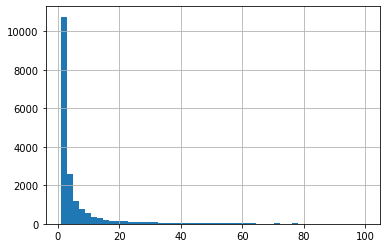

In [6]:
tag_counts[tag_counts <= 100].hist(bins=50)

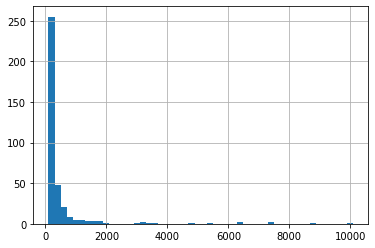

In [7]:
tag_counts[tag_counts > 100].hist(bins=50)

In [8]:
from collections import defaultdict
# import seaborn as sns

tag_counts = defaultdict(int)

for row in tag_posts['_Tag_List']:
    for tag in row:
        tag_counts[tag] += 1

for i in [0, 10, 20, 50, 100, 1000]:
    filtered_tags = list(filter(lambda x: x > i, tag_counts.values()))
    print('There are {:,} tags with more than {:,} count'.format(len(filtered_tags), i))

MIN_TAGS = 50

record_count = len([i for i in filter(lambda x: x > MIN_TAGS, tag_counts.values())])
record_count

There are 18,549 tags with more than 0 count
There are 2,730 tags with more than 10 count
There are 1,589 tags with more than 20 count
There are 709 tags with more than 50 count
There are 367 tags with more than 100 count
There are 33 tags with more than 1,000 count


709

In [9]:
all_tags = set()
for row in tag_posts['_Tag_List']:
    for tag in row:
        if tag_counts[tag] > MIN_TAGS:
            all_tags.add(tag)
print('Total unique tags with {:,} occurrences: {:,}'.format(MIN_TAGS, len(all_tags)))
sorted_all_tags = sorted(all_tags)

tag_to_id = {val:i for i, val in enumerate(sorted_all_tags)}
id_to_tag = {i:val for i, val in enumerate(sorted_all_tags)}

Total unique tags with 50 occurrences: 709


In [10]:
labels = []
tag_list = tag_posts['_Tag_List'].tolist()

# Loop through every post...
for i, tag_set in enumerate(tag_posts['_Tag_List'].tolist()):
    # Then build a record_count element wide list for each tag present
    label_row = []
    for tag in sorted_all_tags:
        if tag in tag_list[i]:
            label_row.append(1)
        else:
            label_row.append(0)
    labels.append(label_row)
    
tag_labels = [id_to_tag[key_id] for key_id in sorted(id_to_tag.keys()) if tag_counts[id_to_tag[key_id]] > MIN_TAGS]

len(labels), len(labels[0]), len(tag_labels)

(98278, 709, 709)

In [11]:
# from bs4 import BeautifulSoup

# MIN_TEXT_LABELS = 50


# def extract_text(x):
#     doc = BeautifulSoup(x)
#     codes = doc.find_all('code')
#     [code.extract() if code else None for code in codes]
#     return doc.text

# post_text = tag_posts._Body.apply(extract_text)
# post_text_words = [x.split() for x in post_text.tolist()]

# text_word_counts = defaultdict(int)
# all_text_words = set()
# for post in post_text_words:
#     for word in post:
#         text_word_counts[word] += 1
#         all_text_words.add(word)

# sorted_all_text_words = sorted(all_text_words)
# print('All text words: {:,}'.format(len(sorted_all_text_words)))

# text_word_to_id = {word:i for i, word in enumerate(sorted_all_text_words)}
# text_id_to_word = {i:word for i, word in enumerate(sorted_all_text_words)}


# # Take words with > MIN_CODE_LABELS/MIN_TEXT_LABELS (20) instances and build a new set of records and labels/label counts
# # encoded_code = []
# encoded_text = []
# # raw_code_labels = set()
# raw_text_labels = set()
# # encoded_code_labels = set()
# encoded_text_labels = set()
# # encoded_code_label_counts = defaultdict(int)
# encoded_text_label_counts = defaultdict(int)
# # for i, (code, text) in enumerate(zip(post_code_words, post_text_words)):
# for i, text in enumerate(post_text_words):    
#     encoded_text_row = []
#     for word in text:
#         if text_word_counts[word] > MIN_TEXT_LABELS:
#             raw_text_labels.add(word)
#             encoded_text_row.append(text_word_to_id[word])
#             encoded_text_labels.add(text_word_to_id[word])
#             encoded_text_label_counts[word] += 1
    
#     encoded_text.append(encoded_text_row)

# # print('Filtered code words: {:,}'.format(len(encoded_code_labels)))
# print('Filtered text words: {:,}'.format(len(encoded_text_labels)))

    
# # Remove short records that we filtered words
# post_ids = defaultdict(bool)
# post_id_list = []
# filtered_text_words = []
# for i, text in enumerate(encoded_text):
#     if len(text) < 5:
#         pass
#     else:
#         post_ids[i] = True
#         post_id_list.append(i)
#         filtered_text_words.append(text)

# filtered_df = pd.DataFrame({'text': filtered_text_words}) # , 'code': filtered_code_words})
# len(filtered_df.index)

In [12]:
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer


def extract_text(x):
    """Extract non-code text from posts (questions/answers)"""
    doc = BeautifulSoup(x)
    codes = doc.find_all('code')
    [code.extract() if code else None for code in codes]
    return doc.text

post_text = tag_posts._Body.apply(extract_text)

t = Tokenizer(5000)
t.fit_on_texts(post_text)
tokenized_text = t.texts_to_matrix(post_text)
tokenized_text

Using TensorFlow backend.


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [13]:
tokenized_text.shape, len(labels), len(labels[0])

((98278, 5000), 98278, 709)

In [14]:
# label_counts_s = pd.Series(
#     data=[i for i in encoded_text_label_counts.values()],
#     index=[i for i in encoded_text_label_counts.keys()]
# )
# label_counts_s = label_counts_s.sort_values(ascending=False)
# label_counts_s[label_counts_s > 100][label_counts_s < 1000].hist(bins=90)

In [15]:
# label_counts_s[label_counts_s <= 100].hist(bins=10)

In [17]:
# from collections import defaultdict

# # Compute a new class label set and label counts that are non-null to match filtered_code_words
# new_labels = []
# for post_id in post_id_list:
#     label_set = labels[post_id]
#     new_labels.append(label_set)

# # del labels
# len(new_labels)

In [18]:
# Validate the posts match the labels
assert(tokenized_text.shape[0] == len(labels))
print('We are left with {:,} example posts'.format(tokenized_text.shape[0]))

We are left with 98,278 example posts


In [19]:
# filtered_df['labels'] = new_labels

# # filtered_df['code_sums'] = filtered_df['code'].apply(lambda x: sum(x))
# filtered_df['text_sums'] = filtered_df['text'].apply(lambda x: sum(x))
# # filtered_df = filtered_df[(filtered_df['code_sums'] > 0) & (filtered_df['text_sums'] > 0)]
# filtered_df = filtered_df[filtered_df['text_sums'] > 0]

# filtered_df['label_max'] = filtered_df['labels'].apply(lambda x: max(x))
# filtered_df = filtered_df[filtered_df['label_max'] > 0]

# filtered_df.head()

In [20]:
# label_ary = np.array(filtered_df['labels'].tolist())
# print(label_ary.shape)

# label_freq = np.sum(label_ary, axis=1) # / label_ary.shape[1]
# pd.Series(label_freq).hist(bins=6)

In [21]:
TRAINING_COUNT = 10000

# Filter rows with all 0s for tags
label_mx = np.array(labels)
max_per_row = label_mx.max(axis=1)
non_zero_index = np.nonzero(max_per_row)

label_mx = label_mx[non_zero_index][0:TRAINING_COUNT]
tokenized_text = tokenized_text[non_zero_index]

tokenized_text.shape, label_mx.shape

((93287, 5000), (10000, 709))

In [22]:
from sklearn.model_selection import train_test_split

TEST_SPLIT = 0.1

X_train, X_test, y_train, y_test = train_test_split(
    tokenized_text[0:TRAINING_COUNT],
    label_mx,
    test_size=TEST_SPLIT,
    random_state=34
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9000, 5000), (1000, 5000), (9000, 709), (1000, 709))

In [23]:
# from keras.preprocessing.sequence import pad_sequences

# MAX_TEXT_LENGTH = 100

# padded_text_train = pad_sequences(X_train['text'], MAX_TEXT_LENGTH, padding='post')
# padded_text_test  = pad_sequences(X_test['text'], MAX_TEXT_LENGTH, padding='post')

In [24]:
# from keras.models import Sequential
# from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense

# MAX_NB_WORDS = len(encoded_labels)
# EMBEDDING_DIM = 50

# model = Sequential()
# model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(record_count, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.summary()

In [25]:
# # padded_code_train.shape[1], 
# padded_text_train.shape[0], padded_text_train.shape[1]

In [26]:
# # padded_code_train.shape, padded_text_train.shape, padded_code_train.dtype, padded_text_train.dtype, \
# #     y_train.shape, y_test.shape
# padded_text_train.dtype, padded_text_train.shape, padded_text_test.shape, y_train.shape, y_test.shape

In [27]:
from keras.layers import Input, concatenate, Activation, Dense, LSTM, BatchNormalization, Embedding, Dropout
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from keras.models import Model
from keras.optimizers import Adam

MAX_TEXT_NB_WORDS = 5000
TEXT_EMBEDDING_DIM = 64

# Text model
text_input = Input(shape=(X_train.shape[1],))

text_embedding = Embedding(
    MAX_TEXT_NB_WORDS, 
    TEXT_EMBEDDING_DIM, 
    input_length=X_train.shape[1]
)(text_input)

text_embedding_dropout = Dropout(0.2)(text_embedding)

text_lstm = LSTM(
    100, 
    input_shape=(X_train.shape[1], X_train.shape[1] * TEXT_EMBEDDING_DIM)
)(text_embedding_dropout)

text_lstm_dropout = Dropout(0.2)(text_lstm)

text_dense = Dense(record_count, activation='sigmoid')(text_lstm_dropout)

text_batch = BatchNormalization()(text_dense)

text_model = Model(
    inputs=text_input, 
    outputs=text_batch
)

from keras import backend as K

def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

def abs_KL_div(y_true, y_pred):
    y_true = K.clip(y_true, K.epsilon(), None)
    y_pred = K.clip(y_pred, K.epsilon(), None)
    return K.sum(K.abs( (y_true - y_pred) * (K.log(y_true / y_pred))), axis=-1)

text_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[abs_KL_div, f1_score, 'mae'])

text_model.summary()

# model.compile(
#     loss='binary_crossentropy',
#     optimizer='adam',
#     metrics=[abs_KL_div],
# )

# model.summary()

# for layer in model.layers:
#     print(layer, layer.output_shape)


W0715 19:37:33.969153 139693019309888 deprecation_wrapper.py:119] From /home/rjurney/anaconda/envs/deep/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0715 19:37:33.984686 139693019309888 deprecation_wrapper.py:119] From /home/rjurney/anaconda/envs/deep/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0715 19:37:33.986537 139693019309888 deprecation_wrapper.py:119] From /home/rjurney/anaconda/envs/deep/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0715 19:37:33.993327 139693019309888 deprecation_wrapper.py:119] From /home/rjurney/anaconda/envs/deep/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is depre

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 5000, 64)          320000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5000, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 709)               71609     
_________________________________________________________________
batch_normalization_1 (Batch (None, 709)               2836      
Total para

In [28]:
from sklearn.utils.class_weight import compute_sample_weight
from keras.callbacks import EarlyStopping

epochs = 1
batch_size = 32

class_weights = np.sum(y_train, axis=0) / y_train.shape[0]

sample_weights = compute_sample_weight('balanced', y_train)

history = text_model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[
        EarlyStopping(monitor='loss', patience=1, min_delta=0.001),
        EarlyStopping(monitor='val_loss', patience=1, min_delta=0.001),
    ],
)

Train on 8100 samples, validate on 900 samples
Epoch 1/1
8100/8100 [==============================] - 970s 120ms/step - loss: 0.0362 - abs_KL_div: 48.4849 - f1_score: nan - mean_absolute_error: 0.0435 - val_loss: 0.0609 - val_abs_KL_div: 328.2021 - val_f1_score: nan - val_mean_absolute_error: 0.0768


In [29]:
# from sklearn.utils.class_weight import compute_sample_weight
# from keras.callbacks import EarlyStopping

# epochs = 4
# batch_size = 256

# # class_ratios = np.sum(y_train, axis=0) / y_train.shape[0]

# sample_weights = compute_sample_weight('balanced', y_train)

# history = model.fit(
#     [padded_code_train, padded_text_train],
#     y_train,
#     epochs=epochs,
#     batch_size=batch_size,
#     validation_split=0.1,
#     callbacks=[
#         EarlyStopping(monitor='val_loss', patience=1, min_delta=0.001),
#     ],
#     sample_weight=sample_weights
# )

In [30]:
# y_train.max(axis=1).min()

In [33]:
accr = text_model.evaluate(X_test, y_test)#, sample_weight=sample_weights)
accr

1000/1000 [==============================] - 33s 33ms/step


[0.06146065306663513, 328.9180712890625, nan, 0.07679933822154998]

In [ ]:
# %matplotlib inline

# import matplotlib.pyplot as plt

# print(history.history)
# # summarize history for accuracy
# plt.plot(history.history['val_loss'])
# plt.plot(history.history['val_abs_KL_div'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [35]:
from sklearn.metrics import hamming_loss, jaccard_score

import keras.backend as K
import tensorflow as tf

y_pred = text_model.predict(X_test)

sess = tf.Session()
with sess.as_default():
    for cutoff in [0.0001, 0.001, 0.01, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8]:
        y_pred_bin = K.greater(y_pred, cutoff).eval()
        print('Cutoff: {:,}'.format(cutoff))
        print('Hamming loss: {:,}'.format(
            hamming_loss(y_test, y_pred_bin)
        ))
        for j_type in ['micro', 'macro', 'weighted']:
            print('Jaccard {} score: {:,}'.format(
                j_type,
                jaccard_score(y_test, y_pred_bin, average=j_type)
            ))

Cutoff: 0.0001
Hamming loss: 0.15764880112834978
Jaccard micro score: 0.010840899838935202
Jaccard macro score: 0.0017280148355955935
Jaccard weighted score: 0.022350363049125438
Cutoff: 0.001


/home/rjurney/anaconda/envs/deep/lib/python3.6/site-packages/sklearn/metrics/classification.py:778: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples.
  'true or predicted', average, ('jaccard',))


Hamming loss: 0.15764880112834978
Jaccard micro score: 0.010840899838935202
Jaccard macro score: 0.0017280148355955935
Jaccard weighted score: 0.022350363049125438
Cutoff: 0.01
Hamming loss: 0.15764880112834978
Jaccard micro score: 0.010840899838935202
Jaccard macro score: 0.0017280148355955935
Jaccard weighted score: 0.022350363049125438
Cutoff: 0.1
Hamming loss: 0.15764880112834978
Jaccard micro score: 0.010840899838935202
Jaccard macro score: 0.0017280148355955935
Jaccard weighted score: 0.022350363049125438
Cutoff: 0.2
Hamming loss: 0.15764880112834978
Jaccard micro score: 0.010840899838935202
Jaccard macro score: 0.0017280148355955935
Jaccard weighted score: 0.022350363049125438
Cutoff: 0.4
Hamming loss: 0.15764880112834978
Jaccard micro score: 0.010840899838935202
Jaccard macro score: 0.0017280148355955935
Jaccard weighted score: 0.022350363049125438
Cutoff: 0.5
Hamming loss: 0.15764880112834978
Jaccard micro score: 0.010840899838935202
Jaccard macro score: 0.0017280148355955935


In [36]:
y_pred

array([[-0.12053776,  0.18637753, -0.05259228, ..., -0.07408333,
        -0.05609608, -0.05732346],
       [-0.12053776,  0.18637753, -0.05259228, ..., -0.07408333,
        -0.05609608, -0.05732346],
       [-0.12053776,  0.18637753, -0.05259228, ..., -0.07408333,
        -0.05609608, -0.05732346],
       ...,
       [-0.12053776,  0.18637753, -0.05259228, ..., -0.07408333,
        -0.05609608, -0.05732346],
       [-0.12053776,  0.18637753, -0.05259228, ..., -0.07408333,
        -0.05609608, -0.05732346],
       [-0.12053776,  0.18637753, -0.05259228, ..., -0.07408333,
        -0.05609608, -0.05732346]], dtype=float32)

In [ ]:
    y_true = K.variable(y_test)
    y_pred = K.variable(y_pred)

    # Count positive samples.
    c1 = K.sum(K.cast(K.greater(K.clip(y_true * y_pred, 0, 1), 0.1), 'float32'))
    c2 = K.sum(K.cast(K.greater(K.clip(y_pred, 0, 1), 0.1), 'float32'))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)

